# Comparing the performance between D and Python implementations

In [29]:
import numba
from epistochmodels import SIR
from numpy.random import rand, gamma, exponential
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Python implementation
Here we present the equivalent python implementation of the SIR model present in EpiStochModels

In [49]:
# numba.njit(cache=True)
def py_sir(N, tf, *pars):
    """
    Runs simulation.

    :parameters:
    :param N: tamanho da população
    :param tf: tempo final
    :param nsims:  Numero de simulações
    :param pars: parametros
    """
    beta, gam, I0 = pars
    
    t = [0]
    S = [N - I0]
    I = [I0]
    R = [N-(I[-1]+S[-1])]
    dts = []
    while I[-1] > 0 and t[-1] < tf:
        U = rand()
        # Probabilidade de que pelo menos um evento ocorra
        T = beta * S[-1] * I[-1] / N + gam * I[-1]
        # Probabilidade do próximo evento ser uma infecção
        pinf = ((beta / N) * S[-1] * I[-1]) / T

        if U <= pinf:  # próximo evento é uma infecçao
            dt = exponential(1 / T)

            S.append(S[-1] - 1)
            I.append(I[-1] + 1)
            R.append(R[-1])
            t.append(t[-1] + dt)
            dts.append(dt)
        else:  # próximo evento é uma recuperação
            S.append(S[-1])
            I.append(I[-1] - 1)
            R.append(R[-1] + 1)
            # print('removal')
            t.append(t[-1] + exponential(1 / T))  # -np.log(rand())/T)
    
    return (t, np.array([S,I,R]).T)

In [56]:
# Parameters
pop = 1000000
beta = 0.7
gamma = 0.3
tf = 1000
I0=10

In [57]:
%%time
res = py_sir(pop,tf, beta,gamma,I0)

CPU times: user 5.79 s, sys: 65.7 ms, total: 5.85 s
Wall time: 5.85 s


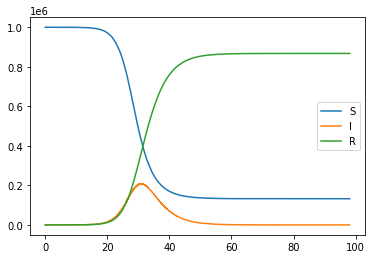

In [58]:
plot(res[0],res[1]);
legend(['S','I','R']);

## Timing the D implementation

In [59]:
model = SIR(pop,beta,gamma)
model.initialize(pop-I0,I0,0)

In [60]:
%%timeit
resD = model.run(0,tf)

1.15 s ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


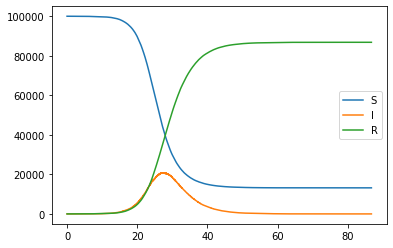

In [61]:
plot(resD[0],resD[1]);
legend(['S','I','R']);

In [28]:
resD[1][-10:]

[[13188, 4, 86808],
 [13188, 3, 86809],
 [13187, 4, 86809],
 [13187, 3, 86810],
 [13187, 2, 86811],
 [13187, 1, 86812],
 [13186, 2, 86812],
 [13186, 1, 86813],
 [13186, 0, 86814],
 [13186, 4294967295, 86815]]